In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt 
import seaborn as sns
import utils
import gensim
import sklearn
import keras

from sklearn_pandas import DataFrameMapper

Using TensorFlow backend.


# the data 

In [3]:
df = utils.parse_csv("data/pocketbook-export.csv", "pocketbook")
print(f"Dataframe shape: {df.shape}")
df.dropna()
print(f"Dataframe shape after dropping nulls: {df.shape}")
df.head()

parsed file with pocketbook parser
Dataframe shape: (4270, 8)
Dataframe shape after dropping nulls: (4270, 8)


,date,description,amount,category,subcategory,merchant,suburb,deal_with_later
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,entertainment,Food,Gusto Italian,Restasuratthani,Thb000000236000
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,utilities,Phone/Internet,Tpg Internet Pty Ltnorth,Ryde,Aud000000005999
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,web hosting,None,Mtpmedia Temple,I8775784000,Usd000000005000
3,2014-04-07,Ebanking Transfer,665.00,transferring money,None,Ebanking Transfer,None,None
4,2014-04-07,Digitalocean Usd000000001000,-10.82,NaN,None,Digitalocean Usd000000001000,None,None


# word2vec

I'm going to use the merchant, suburb and amount to train a classifier to predict the category. So first of all we need to transfrom text into vectors. For that I'm using word2vec on googles pretrained word2vec

In [4]:
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('/Users/ko/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

now i need a set of unique words which are used in my data set. So first getting all the words from the description"

In [5]:
all_words = []
for sentence in df['merchant'].values.astype(str):
    for wrd in sentence.split(" "): 
        all_words.append(wrd.lower())
len(all_words)

9760

now making a set of them:

In [6]:
words_set = set(all_words)
len(words_set)

1556

and then my own dictionary:

In [7]:
word2vec = {}
for wrd in words_set:
    alpha_wrd = "".join([c for c in wrd if c.isalpha()])
    try:
        word2vec[wrd] = np.array(word_vectors.word_vec(alpha_wrd), dtype=np.float64)
    except KeyError:
        word2vec[wrd] = np.array(np.zeros(300,))

        # deal with None values
word2vec[None] = np.array(np.zeros(300,))
word2vec[np.NaN] = np.array(np.zeros(300,))

word2vec["7eleven"].shape, word2vec[np.NaN].shape

((300,), (300,))

In [8]:
word2vec["7eleven"][:10]

array([ 0.13476562, -0.05004883,  0.05859375,  0.16503906,  0.2578125 ,
       -0.21875   , -0.17089844, -0.05517578,  0.08056641,  0.01275635])

Now all our word vectors are numpy arrays of shape (300,). So after our text is vectorized think [SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

## now to convert the text col into vectors

first, to split the text column so there is one col per word

so I'm only going to use the merchant col for now.  

In [10]:
def vectorize_words(s, total_words=3, blank_word=np.zeros(300)):
    """takes in a sentence s, splits it into words, converts each words into a vector,
    then concatanates them and returns a flattened array. if number of words is less than
    total_words, pads with a blank array"""
    list_words = s.split(" ")
    vec = []
    for i in range(total_words):
        try:
            vec.append(word2vec[list_words[i]])
        except:
            vec.append(blank_word)
            
    return np.array(vec).flatten()

a = vectorize_words("gusto italian")
a.shape, a.dtype

((900,), dtype('float64'))

In [16]:
df['merchant'] = df.merchant.str.lower()
df.head(2)

,date,description,amount,category,subcategory,merchant,suburb,deal_with_later
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,entertainment,Food,gusto italian,Restasuratthani,Thb000000236000
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,utilities,Phone/Internet,tpg internet pty ltnorth,Ryde,Aud000000005999


In [773]:
# this code block isn't in use for now, since we don't need to split up the merchant into multiple cols
df['merchant'] = df.merchant.str.lower()
df2 = df['merchant'].str.split(" ", expand=True)
df2.columns = ["feature_" + str(i) for i in range(1,df2.shape[1]+1)]
df2.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,gusto,italian,None,None,None,None
1,tpg,internet,pty,ltnorth,None,None
2,mtpmedia,temple,None,None,None,None
3,ebanking,transfer,None,None,None,None
4,digitalocean,usd000000001000,None,None,None,None


In [17]:
df['merchant_vec'] = df['merchant'].astype(str).apply(vectorize_words)
df.head(3)

,date,description,amount,category,subcategory,merchant,suburb,deal_with_later,merchant_vec
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,entertainment,Food,gusto italian,Restasuratthani,Thb000000236000,"[0.28125, 0.158203125, 0.038330078125, -0.0011..."
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,utilities,Phone/Internet,tpg internet pty ltnorth,Ryde,Aud000000005999,"[0.052734375, 0.2451171875, 0.150390625, 0.265..."
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,web hosting,None,mtpmedia temple,I8775784000,Usd000000005000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## convert category labels into numbers

one way is to turn the categorys into numbers, though ideally we would onehot encode:

In [19]:
df['category'] = df['category'].astype("category")
df['cat'] = df['category'].cat.codes
df.head(3)

,date,description,amount,category,subcategory,merchant,suburb,deal_with_later,merchant_vec,cat
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,entertainment,Food,gusto italian,Restasuratthani,Thb000000236000,"[0.28125, 0.158203125, 0.038330078125, -0.0011...",7
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,utilities,Phone/Internet,tpg internet pty ltnorth,Ryde,Aud000000005999,"[0.052734375, 0.2451171875, 0.150390625, 0.265...",21
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,web hosting,None,mtpmedia temple,I8775784000,Usd000000005000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22


now to make numpy arrays of the data to feed sklean with.

### y data

In [21]:
y_df = df.cat
y_data = np.array(y_df.as_matrix(), dtype=int)
y_data.shape, y_data[:10]

((4270,), array([ 7, 21, 22, 19, -1, 20, 20,  6, 11, -1]))

y looks good, so moving on to x data

### x data

sklearn expects a flat vector. Now there is a better way to do this, but doing this for now:

In [43]:
x_data = []

for row in df['merchant_vec']:
    x_data.append(row)

x_data = np.array(x_data)
print(f"x data shape: {x_data.shape}, {x_data[0].shape}")

x data shape: (4270, 900), (900,)


In [46]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
x_reduced = svd.fit_transform(x_data)

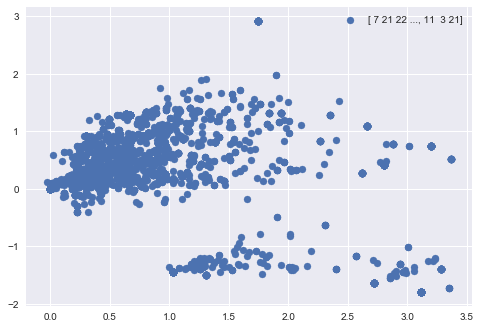

In [70]:
plt.scatter(x_reduced[:,:1], x_reduced[:,1:2], label=y_data)
plt.legend();

# now to actually train a classifier

In [129]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_data, test_size=0.15, random_state=0)
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
clf.score(X_test, y_test)

0.85491419656786272

In [131]:
scores = cross_val_score(clf, X_test, y_test, cv=5)
scores

/Users/ko/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


array([ 0.80740741,  0.7480916 ,  0.796875  ,  0.8       ,  0.81147541])

In [134]:
np.mean(scores)

0.79276988405938176

# ok lets try keras

basic keras model

In [135]:
X_train.shape

(3629, 900)

In [148]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(None, 900)))
model.add(Dense(128, activation='relu'))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [147]:
one_hot_labels = keras.utils.to_categorical(y_train)
X_train.shape

(3629, 900)

In [149]:
model.fit(X_train, y_train, epochs=5, batch_size=64)

ValueError: Error when checking input: expected dense_22_input to have 3 dimensions, but got array with shape (3629, 900)